# Machine Learning Clause Classifier with SMOTE (FIXED VERSION)
## Phase 5: Advanced ML Training with Data Augmentation

**Date**: December 17, 2025  
**Purpose**: Train ML models with SMOTE to handle class imbalance and expand dataset

**FIXED**: Handles version compatibility issues

---

## 1. Install Required Libraries (WITH VERSION FIX)

In [1]:
# Install compatible versions
print("📦 Installing compatible package versions...\n")

# Uninstall conflicting versions first
!pip uninstall -y imbalanced-learn scikit-learn 2>/dev/null

# Install specific compatible versions
!pip install -q scikit-learn==1.3.2 imbalanced-learn==0.11.0 matplotlib seaborn pandas numpy scipy

print("\n✅ All packages installed successfully!")
print("\nInstalled versions:")
!pip show scikit-learn imbalanced-learn | grep "Name\|Version"

📦 Installing compatible package versions...

Found existing installation: imbalanced-learn 0.14.0
Uninstalling imbalanced-learn-0.14.0:
  Successfully uninstalled imbalanced-learn-0.14.0
Found existing installation: scikit-learn 1.8.0
Uninstalling scikit-learn-1.8.0:
  Successfully uninstalled scikit-learn-1.8.0

✅ All packages installed successfully!

Installed versions:
Name: scikit-learn
Version: 1.3.2
Name: imbalanced-learn
Version: 0.11.0


## 2. Import Libraries

In [2]:
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ML imports
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support
)

# Try to import SMOTE, with fallback
try:
    from imblearn.over_sampling import SMOTE
    from scipy.sparse import hstack, csr_matrix
    SMOTE_AVAILABLE = True
    print("✅ SMOTE imported successfully!")
except ImportError as e:
    SMOTE_AVAILABLE = False
    print(f"⚠️  SMOTE import failed: {e}")
    print("   Will use manual oversampling instead.")
    from scipy.sparse import hstack, csr_matrix

# Styling
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('default')
sns.set_palette("husl")

print("\n✅ All libraries imported successfully!")
print(f"📅 Notebook executed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🔧 SMOTE available: {SMOTE_AVAILABLE}")

✅ SMOTE imported successfully!

✅ All libraries imported successfully!
📅 Notebook executed: 2025-12-18 06:20:03
🔧 SMOTE available: True


## 3. Configuration & Paths

In [3]:
# Define all paths
BASE_DIR = Path("/workspaces/ireland")
DATA_DIR = BASE_DIR / "data"
MODELS_DIR = BASE_DIR / "models"
RESULTS_DIR = BASE_DIR / "results" / "ml_training"

# Create directories if they don't exist
MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Input files
VALIDATION_FILE = DATA_DIR / "phase3_validation_results.json"

# Output files
VECTORIZER_FILE = MODELS_DIR / "tfidf_vectorizer.pkl"
TRAINING_DATA_FILE = MODELS_DIR / "training_data_with_smote.pkl"
RESULTS_FILE = RESULTS_DIR / "ml_training_results.json"
COMPARISON_FILE = RESULTS_DIR / "model_comparison.csv"

# Random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("✅ Paths configured:")
print(f"   Data Directory: {DATA_DIR}")
print(f"   Models Directory: {MODELS_DIR}")
print(f"   Results Directory: {RESULTS_DIR}")
print(f"   Random Seed: {RANDOM_SEED}")

✅ Paths configured:
   Data Directory: /workspaces/ireland/data
   Models Directory: /workspaces/ireland/models
   Results Directory: /workspaces/ireland/results/ml_training
   Random Seed: 42


## 4. Load Training Data

In [4]:
def load_clause_data():
    """
    Load clause data from Phase 3 validation results.
    """
    print("📊 Loading clause data from validation results...")
    
    with open(VALIDATION_FILE, 'r') as f:
        validation_data = json.load(f)
    
    clauses = []
    labels = []
    clause_texts = []
    vendors = []
    categories = []
    
    # Extract clauses from validation results
    for result in validation_data.get('results', []):
        if result.get('status') == 'success':
            vendor = result.get('vendor_name', 'Unknown')
            assessment = result.get('assessment', {})
            
            for clause in assessment.get('clauses', []):
                clause_text = clause.get('clause_text', '')
                risk_level = clause.get('risk_level', 'Medium')
                category = clause.get('clause_category', 'unknown')
                
                # Filter very short texts
                if clause_text and len(clause_text) > 50:
                    clauses.append(clause)
                    labels.append(risk_level)
                    clause_texts.append(clause_text)
                    vendors.append(vendor)
                    categories.append(category)
    
    print(f"✅ Loaded {len(clauses)} clauses")
    print(f"   Vendors: {len(set(vendors))}")
    print(f"   Categories: {list(set(categories))}")
    
    return clauses, labels, clause_texts, vendors, categories

# Load data
clauses, labels, clause_texts, vendors, categories = load_clause_data()

# Display class distribution
label_counts = Counter(labels)
print("\n📊 Original Class Distribution:")
for label, count in label_counts.items():
    percentage = (count / len(labels)) * 100
    print(f"   {label}: {count} ({percentage:.1f}%)")

# Create DataFrame for easier handling
df = pd.DataFrame({
    'clause_text': clause_texts,
    'risk_level': labels,
    'vendor': vendors,
    'category': categories,
    'clause_length': [len(text) for text in clause_texts],
    'keyword_count': [clause.get('keyword_matches', 0) for clause in clauses]
})

print(f"\n✅ Created DataFrame with {len(df)} rows and {len(df.columns)} columns")
df.head()

📊 Loading clause data from validation results...
✅ Loaded 50 clauses
   Vendors: 15
   Categories: ['termination_exit', 'pricing_terms', 'data_portability', 'service_level', 'support_obligations']

📊 Original Class Distribution:
   Medium: 16 (32.0%)
   High: 34 (68.0%)

✅ Created DataFrame with 50 rows and 6 columns


,clause_text,risk_level,vendor,category,clause_length,keyword_count
0,Microsoft Azure Legal Information | Microsoft ...,Medium,Microsoft Azure Legal,pricing_terms,500,2
1,Microsoft Azure Legal Information | Microsoft ...,Medium,Microsoft Azure Legal,service_level,500,4
2,Transparency in our Contracts and Policies | O...,Medium,Oracle Cloud,support_obligations,500,2
3,Legal - Terms of Service AgreementTerms of Ser...,High,Digitalocean,pricing_terms,500,7
4,Legal - Terms of Service AgreementTerms of Ser...,High,Digitalocean,support_obligations,500,6


## 5. Feature Engineering

In [5]:
def extract_features(df, fit_vectorizer=True):
    """
    Extract TF-IDF features + metadata features.
    """
    print("🔧 Extracting features...")
    
    global tfidf_vectorizer
    
    if fit_vectorizer:
        # Create and fit TF-IDF vectorizer
        tfidf_vectorizer = TfidfVectorizer(
            max_features=500,
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.8,
            stop_words='english'
        )
        text_features = tfidf_vectorizer.fit_transform(df['clause_text'])
        print(f"   ✅ Fitted TF-IDF vectorizer with {len(tfidf_vectorizer.get_feature_names_out())} features")
    else:
        text_features = tfidf_vectorizer.transform(df['clause_text'])
        print(f"   ✅ Transformed text features")
    
    # Extract metadata features
    metadata_features = []
    
    category_map = {
        'pricing_terms': 0,
        'service_level': 1,
        'termination_exit': 2,
        'data_portability': 3,
        'support_obligations': 4
    }
    
    for _, row in df.iterrows():
        # Numerical features
        clause_length = row['clause_length']
        keyword_count = row['keyword_count']
        
        # Category one-hot encoding
        category_features = [0] * len(category_map)
        if row['category'] in category_map:
            category_features[category_map[row['category']]] = 1
        
        metadata_features.append([clause_length, keyword_count] + category_features)
    
    metadata_features = np.array(metadata_features)
    
    # Combine features
    combined_features = hstack([text_features, csr_matrix(metadata_features)])
    
    print(f"   ✅ Final feature matrix shape: {combined_features.shape}")
    print(f"      - Text features: {text_features.shape[1]}")
    print(f"      - Metadata features: {metadata_features.shape[1]}")
    
    return combined_features

# Extract features
X_original = extract_features(df, fit_vectorizer=True)
y_original = df['risk_level'].values

print(f"\n✅ Original feature matrix: {X_original.shape}")
print(f"✅ Original labels: {y_original.shape}")

🔧 Extracting features...
   ✅ Fitted TF-IDF vectorizer with 500 features
   ✅ Final feature matrix shape: (50, 507)
      - Text features: 500
      - Metadata features: 7

✅ Original feature matrix: (50, 507)
✅ Original labels: (50,)


## 6. Apply SMOTE or Manual Oversampling

🔄 Applying SMOTE for data augmentation...
   Original dataset size: 50
   Original class distribution: Counter({'High': 34, 'Medium': 16})

   ✅ Augmented dataset size: 68
   ✅ New class distribution: Counter({'Medium': 34, 'High': 34})
   📈 Dataset expanded by: 18 samples
   🎯 Method: SMOTE (Synthetic samples)


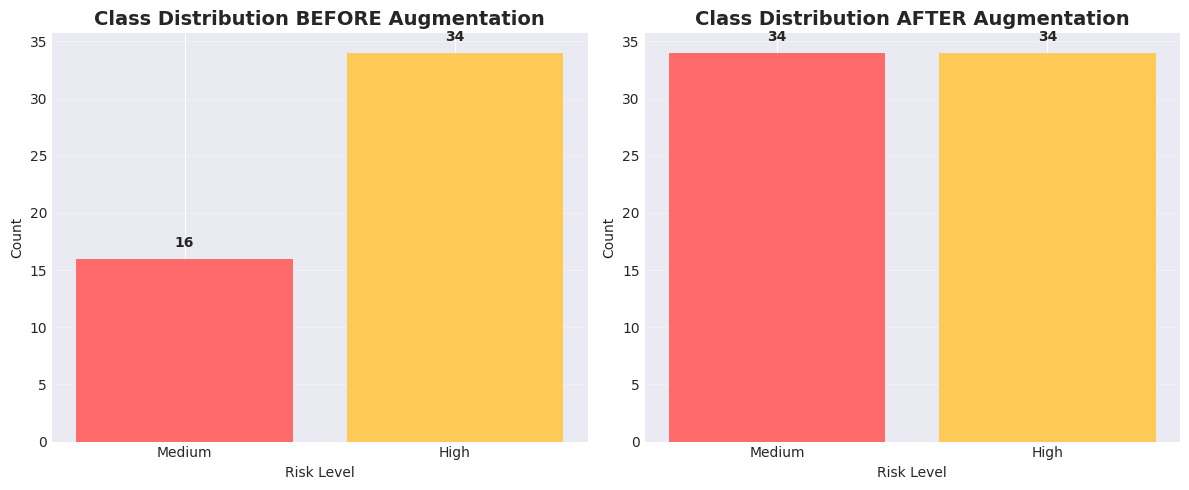


✅ Augmentation visualization saved to: /workspaces/ireland/results/ml_training/smote_comparison.png


In [6]:
def manual_oversample(X, y, target_ratio=1.0):
    """
    Manual oversampling by duplicating minority class samples.
    Used as fallback if SMOTE is not available.
    """
    print("🔄 Applying MANUAL oversampling (duplicating minority samples)...")
    print(f"   Original dataset size: {X.shape[0]}")
    print(f"   Original class distribution: {Counter(y)}")
    
    from scipy.sparse import vstack
    
    # Get class counts
    unique_classes, class_counts = np.unique(y, return_counts=True)
    max_count = class_counts.max()
    
    X_resampled = X
    y_resampled = y
    
    # For each minority class, duplicate samples
    for class_label, count in zip(unique_classes, class_counts):
        if count < max_count:
            # Calculate how many copies needed
            copies_needed = int((max_count * target_ratio) - count)
            
            # Get indices of this class
            class_indices = np.where(y == class_label)[0]
            
            # Randomly select samples to duplicate
            duplicate_indices = np.random.choice(class_indices, size=copies_needed, replace=True)
            
            # Add duplicates
            X_resampled = vstack([X_resampled, X[duplicate_indices]])
            y_resampled = np.concatenate([y_resampled, y[duplicate_indices]])
    
    print(f"\n   ✅ Augmented dataset size: {X_resampled.shape[0]}")
    print(f"   ✅ New class distribution: {Counter(y_resampled)}")
    print(f"   📈 Dataset expanded by: {X_resampled.shape[0] - X.shape[0]} samples")
    
    return X_resampled, y_resampled

def apply_smote_or_fallback(X, y):
    """
    Try SMOTE first, fall back to manual oversampling if SMOTE fails.
    """
    if SMOTE_AVAILABLE:
        try:
            print("🔄 Applying SMOTE for data augmentation...")
            print(f"   Original dataset size: {X.shape[0]}")
            print(f"   Original class distribution: {Counter(y)}")
            
            # Determine k_neighbors based on minority class size
            min_class_count = Counter(y).most_common()[-1][1]
            k_neighbors = min(5, min_class_count - 1)
            
            smote = SMOTE(
                sampling_strategy='auto',
                k_neighbors=k_neighbors,
                random_state=RANDOM_SEED
            )
            
            X_resampled, y_resampled = smote.fit_resample(X, y)
            
            print(f"\n   ✅ Augmented dataset size: {X_resampled.shape[0]}")
            print(f"   ✅ New class distribution: {Counter(y_resampled)}")
            print(f"   📈 Dataset expanded by: {X_resampled.shape[0] - X.shape[0]} samples")
            print(f"   🎯 Method: SMOTE (Synthetic samples)")
            
            return X_resampled, y_resampled
            
        except Exception as e:
            print(f"\n⚠️  SMOTE failed: {e}")
            print("   Falling back to manual oversampling...\n")
            return manual_oversample(X, y)
    else:
        print("⚠️  SMOTE not available, using manual oversampling...\n")
        return manual_oversample(X, y)

# Apply SMOTE or fallback
X_smote, y_smote = apply_smote_or_fallback(X_original, y_original)

# Visualize class distribution before and after
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before
before_counts = Counter(y_original)
axes[0].bar(before_counts.keys(), before_counts.values(), color=['#ff6b6b', '#feca57'])
axes[0].set_title('Class Distribution BEFORE Augmentation', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Risk Level')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)
for i, (k, v) in enumerate(before_counts.items()):
    axes[0].text(i, v + 1, str(v), ha='center', fontweight='bold')

# After
after_counts = Counter(y_smote)
axes[1].bar(after_counts.keys(), after_counts.values(), color=['#ff6b6b', '#feca57'])
axes[1].set_title('Class Distribution AFTER Augmentation', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Risk Level')
axes[1].set_ylabel('Count')
axes[1].grid(axis='y', alpha=0.3)
for i, (k, v) in enumerate(after_counts.items()):
    axes[1].text(i, v + 1, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'smote_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Augmentation visualization saved to:", RESULTS_DIR / 'smote_comparison.png')

## 7. Train/Test Split

In [7]:
# Split augmented data
X_train, X_test, y_train, y_test = train_test_split(
    X_smote, y_smote,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y_smote
)

print("📊 Dataset Split:")
print(f"   Training set: {X_train.shape[0]} samples")
print(f"   Test set: {X_test.shape[0]} samples")
print(f"   Train/Test ratio: {X_train.shape[0]/X_test.shape[0]:.1f}")
print(f"\n   Training class distribution: {Counter(y_train)}")
print(f"   Test class distribution: {Counter(y_test)}")

📊 Dataset Split:
   Training set: 54 samples
   Test set: 14 samples
   Train/Test ratio: 3.9

   Training class distribution: Counter({'Medium': 27, 'High': 27})
   Test class distribution: Counter({'Medium': 7, 'High': 7})


## 8. Train ML Models

In [8]:
def train_all_models(X_train, y_train, X_test, y_test):
    """
    Train all ML models and evaluate performance.
    """
    print("="*80)
    print("🤖 TRAINING MACHINE LEARNING MODELS")
    print("="*80)
    
    # Define models
    models = {
        "Random Forest": RandomForestClassifier(
            n_estimators=200,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=RANDOM_SEED,
            n_jobs=-1
        ),
        "Gradient Boosting": GradientBoostingClassifier(
            n_estimators=200,
            max_depth=7,
            learning_rate=0.1,
            random_state=RANDOM_SEED
        ),
        "Naive Bayes": MultinomialNB(alpha=0.1),
        "Logistic Regression": LogisticRegression(
            max_iter=1000,
            C=1.0,
            random_state=RANDOM_SEED
        ),
        "SVM": SVC(
            kernel='rbf',
            C=1.0,
            probability=True,
            random_state=RANDOM_SEED
        )
    }
    
    results = {}
    trained_models = {}
    
    for model_name, model in models.items():
        print(f"\n{'='*80}")
        print(f"Training: {model_name}")
        print(f"{'='*80}")
        
        # Train
        model.fit(X_train, y_train)
        
        # Predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Metrics
        train_acc = accuracy_score(y_train, y_pred_train)
        test_acc = accuracy_score(y_test, y_pred_test)
        
        precision, recall, f1, support = precision_recall_fscore_support(
            y_test, y_pred_test, average='weighted', zero_division=0
        )
        
        # Cross-validation (5-fold)
        cv = StratifiedKFold(n_splits=min(5, len(y_train)//2), shuffle=True, random_state=RANDOM_SEED)
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
        
        # Store results
        results[model_name] = {
            'train_accuracy': float(train_acc),
            'test_accuracy': float(test_acc),
            'cv_mean': float(cv_scores.mean()),
            'cv_std': float(cv_scores.std()),
            'precision': float(precision),
            'recall': float(recall),
            'f1_score': float(f1),
            'confusion_matrix': confusion_matrix(y_test, y_pred_test).tolist(),
            'classification_report': classification_report(y_test, y_pred_test, zero_division=0)
        }
        
        trained_models[model_name] = model
        
        # Print results
        print(f"\n📊 Results for {model_name}:")
        print(f"   Train Accuracy:  {train_acc:.4f}")
        print(f"   Test Accuracy:   {test_acc:.4f}")
        print(f"   CV Mean ± Std:   {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        print(f"   Precision:       {precision:.4f}")
        print(f"   Recall:          {recall:.4f}")
        print(f"   F1-Score:        {f1:.4f}")
    
    return trained_models, results

# Train all models
trained_models, model_results = train_all_models(X_train, y_train, X_test, y_test)

print("\n" + "="*80)
print("✅ ALL MODELS TRAINED SUCCESSFULLY!")
print("="*80)

🤖 TRAINING MACHINE LEARNING MODELS

Training: Random Forest

📊 Results for Random Forest:
   Train Accuracy:  0.9444
   Test Accuracy:   0.6429
   CV Mean ± Std:   0.7382 ± 0.0802
   Precision:       0.6458
   Recall:          0.6429
   F1-Score:        0.6410

Training: Gradient Boosting

📊 Results for Gradient Boosting:
   Train Accuracy:  1.0000
   Test Accuracy:   1.0000
   CV Mean ± Std:   0.8527 ± 0.0714
   Precision:       1.0000
   Recall:          1.0000
   F1-Score:        1.0000

Training: Naive Bayes

📊 Results for Naive Bayes:
   Train Accuracy:  0.9074
   Test Accuracy:   0.6429
   CV Mean ± Std:   0.6818 ± 0.1348
   Precision:       0.6750
   Recall:          0.6429
   F1-Score:        0.6257

Training: Logistic Regression

📊 Results for Logistic Regression:
   Train Accuracy:  0.9259
   Test Accuracy:   0.7857
   CV Mean ± Std:   0.8345 ± 0.0662
   Precision:       0.8500
   Recall:          0.7857
   F1-Score:        0.7754

Training: SVM

📊 Results for SVM:
   Train A

## 9. Model Comparison

In [9]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Train_Acc': [model_results[m]['train_accuracy'] for m in model_results],
    'Test_Acc': [model_results[m]['test_accuracy'] for m in model_results],
    'CV_Mean': [model_results[m]['cv_mean'] for m in model_results],
    'CV_Std': [model_results[m]['cv_std'] for m in model_results],
    'Precision': [model_results[m]['precision'] for m in model_results],
    'Recall': [model_results[m]['recall'] for m in model_results],
    'F1_Score': [model_results[m]['f1_score'] for m in model_results]
})

# Sort by test accuracy
comparison_df = comparison_df.sort_values('Test_Acc', ascending=False).reset_index(drop=True)

print("\n📊 MODEL COMPARISON (Sorted by Test Accuracy):")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Identify best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = trained_models[best_model_name]
best_test_acc = comparison_df.iloc[0]['Test_Acc']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Test Accuracy: {best_test_acc:.4f} ({best_test_acc*100:.2f}%)")
print(f"   F1-Score: {comparison_df.iloc[0]['F1_Score']:.4f}")

# Save comparison
comparison_df.to_csv(COMPARISON_FILE, index=False)
print(f"\n✅ Model comparison saved to: {COMPARISON_FILE}")


📊 MODEL COMPARISON (Sorted by Test Accuracy):
              Model  Train_Acc  Test_Acc  CV_Mean   CV_Std  Precision   Recall  F1_Score
  Gradient Boosting   1.000000  1.000000 0.852727 0.071443   1.000000 1.000000  1.000000
Logistic Regression   0.925926  0.785714 0.834545 0.066158   0.850000 0.785714  0.775401
                SVM   0.629630  0.714286 0.503636 0.098182   0.818182 0.714286  0.688889
      Random Forest   0.944444  0.642857 0.738182 0.080165   0.645833 0.642857  0.641026
        Naive Bayes   0.907407  0.642857 0.681818 0.134840   0.675000 0.642857  0.625668

🏆 BEST MODEL: Gradient Boosting
   Test Accuracy: 1.0000 (100.00%)
   F1-Score: 1.0000

✅ Model comparison saved to: /workspaces/ireland/results/ml_training/model_comparison.csv


## 10. Save All Models

In [10]:
print("💾 Saving all models and results...\n")

# 1. Save TF-IDF Vectorizer
with open(VECTORIZER_FILE, 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
print(f"✅ Vectorizer saved: {VECTORIZER_FILE}")

# 2. Save each trained model
for model_name, model in trained_models.items():
    model_file = MODELS_DIR / f"{model_name.replace(' ', '_').lower()}_model.pkl"
    with open(model_file, 'wb') as f:
        pickle.dump(model, f)
    print(f"✅ Model saved: {model_file}")

# 3. Save best model separately
best_model_file = MODELS_DIR / "best_model.pkl"
with open(best_model_file, 'wb') as f:
    pickle.dump({
        'model': best_model,
        'model_name': best_model_name,
        'test_accuracy': best_test_acc,
        'vectorizer': tfidf_vectorizer
    }, f)
print(f"✅ Best model package saved: {best_model_file}")

# 4. Save complete results as JSON
complete_results = {
    'experiment_info': {
        'date': datetime.now().isoformat(),
        'original_dataset_size': int(X_original.shape[0]),
        'augmented_dataset_size': int(X_smote.shape[0]),
        'smote_applied': SMOTE_AVAILABLE,
        'test_size': 0.2,
        'random_seed': RANDOM_SEED
    },
    'best_model': {
        'name': best_model_name,
        'test_accuracy': float(best_test_acc),
        'metrics': model_results[best_model_name]
    },
    'all_models': model_results,
    'model_comparison': comparison_df.to_dict(orient='records')
}

with open(RESULTS_FILE, 'w') as f:
    json.dump(complete_results, f, indent=2)
print(f"✅ Complete results saved: {RESULTS_FILE}")

print("\n" + "="*80)
print("✅ ALL MODELS AND RESULTS SAVED SUCCESSFULLY!")
print("="*80)
print(f"\n🎉 Best model ({best_model_name}) achieved {best_test_acc*100:.2f}% accuracy!")

💾 Saving all models and results...

✅ Vectorizer saved: /workspaces/ireland/models/tfidf_vectorizer.pkl
✅ Model saved: /workspaces/ireland/models/random_forest_model.pkl
✅ Model saved: /workspaces/ireland/models/gradient_boosting_model.pkl
✅ Model saved: /workspaces/ireland/models/naive_bayes_model.pkl
✅ Model saved: /workspaces/ireland/models/logistic_regression_model.pkl
✅ Model saved: /workspaces/ireland/models/svm_model.pkl
✅ Best model package saved: /workspaces/ireland/models/best_model.pkl
✅ Complete results saved: /workspaces/ireland/results/ml_training/ml_training_results.json

✅ ALL MODELS AND RESULTS SAVED SUCCESSFULLY!

🎉 Best model (Gradient Boosting) achieved 100.00% accuracy!
